## T1 mapping algorithm from the UK7t PSIR/MP2RAGE acquisition

The following notebook is structured as follow: it loads in the individual TIs from the PSIR/MP2RAGE acquisition as well as the B1 map, it creates the PSIR and MP2RAGE images without and with noise correction, it creates a LUT for the actual acquisition (if not present already) and it outputs the computed T1 maps.

The supported format is the Philips format (PAR/REC), the output of the dcm2niix format (default flags), or the output of the ptoa software. If another format is necessary, it should be specify using the recon flag. 

The creation of the LUT takes approximately one hour on a standard PC, and is saved in a file that can be loaded again (check that the directory is fine: at the moment it is saved in the code directory)

In [1]:
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
#from nilearn import image
import subprocess
# to save and retrieve the LUT
try:
    # cpickle faster, so try to import it if present
    import cPickle as pickle
except:
    import pickle

## for debugging:
import time


In [2]:
def load_parrec(parfile):
    print(parfile)
    img = nib.load(parfile, scaling='fp', strict_sort=True)
    hdr = img.header
    try:
        vols = img.shape[3]
    except IndexError:
        vols = 1
    sort = hdr.get_volume_labels()
    print(sort)

    labels = hdr.get_volume_labels()
    sorted_indices = hdr.get_sorted_slice_indices()
    # From the PAR files, info per slice of cardiac, mod/phase, etc...
    image_defs = hdr.image_defs
    sl_indices = image_defs['slice number'][sorted_indices]

    # Load the image data
    data = img.get_fdata()  
    sub_data = np.zeros(data.shape[0:3])

    print(image_defs)
    
    for cardiac in np.nditer(np.unique(image_defs['cardiac phase number'])):
        for phase in np.nditer(np.unique(image_defs['image_type_mr'])):
            sub_data = data[:, :, :, np.logical_and.reduce((sort['cardiac phase number'] == cardiac,
                                                            sort['image_type_mr'] == phase))]
            print(str(phase) + ' ' + str(cardiac-1))

            if sub_data.shape[3] != 0:
                # Make an output file name
                out_name = parfile[:-4]
                if phase==3:
                    out_name += '_phase'
                else:
                    out_name += '_modulus'
                out_name += '_cphase0' + str(cardiac-1)                                             
                out_name += '.nii.gz'
                print(out_name)

                # Make the nifti image object and save it
                img_out = nib.Nifti1Image(sub_data, img.affine)
                nib.save(img_out, out_name)


In [3]:
def show_slices(slices,clims=[0.0,0.0]):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1,len(slices))
    for i, slice in enumerate(slices):
        if clims==[0.0,0.0]:
            axes[i].imshow(slice.T, cmap='gray', origin="lower")
        else:
            axes[i].imshow(slice.T, cmap='gray', origin="lower", clim=clims)
            
def maxk(A,k):
    B=np.sort(np.ndarray.flatten(A))
    t=size(B)
    y=B[t-k+1:]
    return y

def size(A):
    sizei = 1
    for dim in np.shape(A): sizei *= dim
    return sizei

def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()    

In [4]:
def create_LUT():

    # LUT parameters
    maxB1=200
    maxT1=3000

    # Scanning parameters from the UK7T protocol:
    SSi=5000 # TR between inversions
    TR=16 # Echo spacing during the shot
    TFE=64 # Number of shot per inversion
    FAt1=8 # First flip angle
    FAt2=5 # Second flip angle
    TI1min=570 # Minimum TI for the first shot: need to compute
    TI1_=1080;# First Inversion Time
    TIbis2=150; # Minimum TI for the second shot
    TIbis=TI1_ + np.ceil(TFE/2*TR)+TIbis2; # timing for the middle of the sequence
    TFE_bis=TFE/2

    # Time sampling in 10th of ms
    SSi10=SSi*10
    T = range(SSi10) # time variable
    TR10=int(10*TR)
    TR9=TR10-1 #TR minus one time tick...
    TIbis10=int(TIbis*10)  # TIbisi
    TI1_10=int(TI1_*10) # TI1a and TI1i
    TI4_10=int(TIbis10+TI1_10) # TI4i

    TI0_10=int(TI1_10-np.ceil(TFE_bis*TR10))
    TI2_10=int(TI1_10+np.ceil(TFE_bis*TR10))
    TI3_10=int(TI4_10-np.ceil(TFE_bis*TR10))
    TI5_10=int(TI4_10+np.ceil(TFE_bis*TR10))       

    if TI0_10<0:
        os.error('Error, wrong timing: please readjust sequence timing!')

    # Create RF timing vector:
    RF=np.zeros_like(T,dtype=bool)
    for i in range(TI0_10,TI2_10,1):
        if not np.mod(i-TI0_10,TR10):       
            RF[i]=True 
    for i in range(TI3_10,TI5_10,1):
        if not np.mod(i-TI3_10,TR10):       
            RF[i]=True 

    fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
    ax1.plot(RF)
    ax1.set_title('RF plot')

    Mwm=0.71 # Proton density between WM and GM: no effect on the LUT

    FB=180 # Flip angle for the inversion
    eff=0.95 # Efficiency of the adiabatic pulse
    cosFB=np.cos(np.deg2rad(eff*FB))

    # Range of the LUT
    B1m=range(1,maxB1+1,1)
    T1m=range(1,maxT1+1,1)

    # Indice to +1 to keep index right: first cell is empty as B1=0 and T1=0 empty
    LUT_INV1=np.zeros((maxB1+1,maxT1+1))
    LUT_INV2=np.zeros_like(LUT_INV1)
    LUT_MP2RAGE=np.zeros_like(LUT_INV1)
    LUT_PSIR=np.zeros_like(LUT_INV1)

    for T1tmp in T1m:
        printProgressBar(T1tmp,maxT1,'LUT progress')
        expmT1=np.exp(-0.1/T1tmp)
        expTRT1=np.exp(-(TR-0.1)/T1tmp)
        Mwm0=Mwm*(1-np.exp(-SSi/T1tmp))

        for B1tmp in B1m:
            FA1=FAt1*B1tmp/100;cosFA1=np.cos(np.deg2rad(FA1));sinFA1=np.sin(np.deg2rad(FA1))
            FA2=FAt2*B1tmp/100;cosFA2=np.cos(np.deg2rad(FA2));sinFA2=np.sin(np.deg2rad(FA2))

            # Initialisation
            M=np.zeros((1,len(T)))

            # 5 shots to be in steady-state:
            # three generally suficient for most B1/T1 combination but 5 necessary for LUT
            for shot in range(5):
                # Inversion first: taking into account efficiency and timing of the pulse (12ms)
                M[0,1]=cosFB*M[0,0]
                M[0,120]=M[0,1]
                # relaxation before acquisition
                M[0,TI0_10-1]=Mwm+(M[0,120]-Mwm)*np.exp(-(float(TI0_10-1-120)/10.)/T1tmp)

                i=TI0_10
                while i <= TI1_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA1*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9
                
                # Signal in image 1
                INV1=sinFA1*M[0,TI1_10-1]

                i=TI1_10
                while i <= TI2_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA1*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9  
                
                # relaxation between the two acquisition
                M[0,TI3_10-1]=Mwm+(M[0,TI2_10-1]-Mwm)*np.exp(-float(TI3_10-1-TI2_10)/10./T1tmp)

                i=TI3_10
                while i <= TI4_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA2*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9

                # Signal in image 2
                INV2=sinFA2*M[0,TI4_10-1]                  

                i=TI4_10
                while i <= TI5_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA2*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9

                # relaxation after the second acquisition
                M[0,SSi10-1]=Mwm+(M[0,TI5_10-1]-Mwm)*np.exp(-(float(SSi10-1-TI5_10)/10.)/T1tmp)    

                # Reassignment of magnetisation for the start of the next shot
                M[0,0]=M[0,SSi10-1]
            
            # Add signals to existing arrays after each iteration
            LUT_INV1[B1tmp,T1tmp]=INV1
            LUT_INV2[B1tmp,T1tmp]=INV2

            # Plot of the magnetisation?
            if T1tmp==1001:
                ax2.plot(M[0,:])
                ax2.set_title('Signal plot')

    # Calculating PSIR & MP2RAGE signals
    #beta=max(np.abs(LUT_INV2.flatten()))
    LUT_PSIR = LUT_INV1/(abs(LUT_INV1)+abs(LUT_INV2))
    # PSIR_beta= ((LUT_INV1-beta)./(abs(LUT_INV1+LUT_INV2)+beta)+1)*1000;
    LUT_MP2RAGE = LUT_INV1*LUT_INV2/(LUT_INV1**2+LUT_INV2**2)

    with open('LUT_thalamus_1080ms.pkl','wb') as f:
        pickle.dump([LUT_INV1,LUT_INV2,LUT_PSIR,LUT_MP2RAGE,T1m,B1m],f)        
    ###### save raw to pickle file ###########   

    


In [5]:
def create_LUT2():

    # LUT parameters
    maxB1=200
    maxT1=3000

    # Scanning parameters from the UK7T protocol:
    SSi=5000 # TR between inversions
    TR=6.3 # Echo spacing during the shot
    TFE=224 # Number of shot per inversion
    FAt1=6 # First flip angle
    FAt2=3 # Second flip angle
    TI1min=798 # Minimum TI for the first shot: need to compute
    TI1_=800;# First Inversion Time
    TIbis2=205; # Minimum TI for the second shot
    TIbis=TI1_ + np.ceil(TFE/2*TR)+TIbis2; # timing for the middle of the sequence
    TFE_bis=TFE/2

    # Time sampling in 10th of ms
    SSi10=SSi*10
    T = range(SSi10) # time variable
    TR10=int(10*TR)
    TR9=TR10-1 #TR minus one time tick...
    TIbis10=int(TIbis*10)  # TIbisi
    TI1_10=int(TI1_*10) # TI1a and TI1i
    TI4_10=int(TIbis10+TI1_10) # TI4i

    TI0_10=int(TI1_10-np.ceil(TFE_bis*TR10))
    TI2_10=int(TI1_10+np.ceil(TFE_bis*TR10))
    TI3_10=int(TI4_10-np.ceil(TFE_bis*TR10))
    TI5_10=int(TI4_10+np.ceil(TFE_bis*TR10))       

    if TI0_10<0:
        os.error('Error, wrong timing: please readjust sequence timing!')

    # Create RF timing vector:
    RF=np.zeros_like(T,dtype=bool)
    for i in range(TI0_10,TI2_10,1):
        if not np.mod(i-TI0_10,TR10):       
            RF[i]=True 
    for i in range(TI3_10,TI5_10,1):
        if not np.mod(i-TI3_10,TR10):       
            RF[i]=True 

    fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
    ax1.plot(RF)
    ax1.set_title('RF plot')

    Mwm=0.71 # Proton density between WM and GM: no effect on the LUT

    FB=180 # Flip angle for the inversion
    eff=0.95 # Efficiency of the adiabatic pulse
    cosFB=np.cos(np.deg2rad(eff*FB))

    # Range of the LUT
    B1m=range(1,maxB1+1,1)
    T1m=range(1,maxT1+1,1)

    # Indice to +1 to keep index right: first cell is empty as B1=0 and T1=0 empty
    LUT_INV1=np.zeros((maxB1+1,maxT1+1))
    LUT_INV2=np.zeros_like(LUT_INV1)
    LUT_MP2RAGE=np.zeros_like(LUT_INV1)
    LUT_PSIR=np.zeros_like(LUT_INV1)

    for T1tmp in T1m:
        printProgressBar(T1tmp,maxT1,'LUT progress')
        expmT1=np.exp(-0.1/T1tmp)
        expTRT1=np.exp(-(TR-0.1)/T1tmp)
        Mwm0=Mwm*(1-np.exp(-SSi/T1tmp))

        for B1tmp in B1m:
            FA1=FAt1*B1tmp/100;cosFA1=np.cos(np.deg2rad(FA1));sinFA1=np.sin(np.deg2rad(FA1))
            FA2=FAt2*B1tmp/100;cosFA2=np.cos(np.deg2rad(FA2));sinFA2=np.sin(np.deg2rad(FA2))

            # Initialisation
            M=np.zeros((1,len(T)))

            # 5 shots to be in steady-state:
            # three generally suficient for most B1/T1 combination but 5 necessary for LUT
            for shot in range(5):
                # Inversion first: taking into account efficiency and timing of the pulse (12ms)
                M[0,1]=cosFB*M[0,0]
                M[0,120]=M[0,1]
                # relaxation before acquisition
                M[0,TI0_10-1]=Mwm+(M[0,120]-Mwm)*np.exp(-(float(TI0_10-1-120)/10.)/T1tmp)

                i=TI0_10
                while i <= TI1_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA1*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9
                
                # Signal in image 1
                INV1=sinFA1*M[0,TI1_10-1]

                i=TI1_10
                while i <= TI2_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA1*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9  
                
                # relaxation between the two acquisition
                M[0,TI3_10-1]=Mwm+(M[0,TI2_10-1]-Mwm)*np.exp(-float(TI3_10-1-TI2_10)/10./T1tmp)

                i=TI3_10
                while i <= TI4_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA2*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9

                # Signal in image 2
                INV2=sinFA2*M[0,TI4_10-1]                  

                i=TI4_10
                while i <= TI5_10:
                    if RF[i]:
                        M[0,i]=Mwm+(cosFA2*M[0,i-1]-Mwm)*expmT1 # Every RF pulses
                        i+=1
                    else:
                        M[0,i+TR9-1]=Mwm+(M[0,i-1]-Mwm)*expTRT1
                        i+=TR9

                # relaxation after the second acquisition
                M[0,SSi10-1]=Mwm+(M[0,TI5_10-1]-Mwm)*np.exp(-(float(SSi10-1-TI5_10)/10.)/T1tmp)    

                # Reassignment of magnetisation for the start of the next shot
                M[0,0]=M[0,SSi10-1]
            
            # Add signals to existing arrays after each iteration
            LUT_INV1[B1tmp,T1tmp]=INV1
            LUT_INV2[B1tmp,T1tmp]=INV2

            # Plot of the magnetisation?
            if T1tmp==1001:
                ax2.plot(M[0,:])
                ax2.set_title('Signal plot')

    # Calculating PSIR & MP2RAGE signals
    #beta=max(np.abs(LUT_INV2.flatten()))
    LUT_PSIR = LUT_INV1/(abs(LUT_INV1)+abs(LUT_INV2))
    # PSIR_beta= ((LUT_INV1-beta)./(abs(LUT_INV1+LUT_INV2)+beta)+1)*1000;
    LUT_MP2RAGE = LUT_INV1*LUT_INV2/(LUT_INV1**2+LUT_INV2**2)

    with open('LUT_Pitts.pkl','wb') as f:
        pickle.dump([LUT_INV1,LUT_INV2,LUT_PSIR,LUT_MP2RAGE,T1m,B1m],f)        
    ###### save raw to pickle file ###########   

    


In [6]:
print('Number of arguments:', len(sys.argv), 'arguments.')
a=sys.argv[1:]
print('Argument List:', a)

if not a:
    print('Please provide arguments for the python script:')
    print('    first argument: directory where the data is stored')
    print('    second argument: subject ID of the patient (prefix of the image name, including the scan number)')
    print('                     (for example Subject_01_PSIR_6_1 )')
    print('    third argument: suffix of the image (either .img, .nii or .nii.gz)')
    print('    fourth argument: reconstruction software (either ptoa or dcm2niix)')
    print('    fifth argument: protocol used for the PSIR (either UK7T or Pitts)')
    print('    sixth argument (optional): subject ID of the B1 (as for the second argument)')
    print('                     (for example Subject_01_B1map_7_1 )')
    print('N.B.: Please check that there is no full stop (.) inside the file name.')
    sys.exit()
elif a[0]=='-f' or a[0]=='--ip=127.0.0.1':
    print('You are on the notebook, please check below the ID, directory and suffix of images provided.')
    in_dir='C:\\Users\\ppzom1\\OneDrive - The University of Nottingham\\Documents\\data\\7T\\Thalamus\\MP2RAGE\\'
    protocol='thalamus_1080ms'
    sub_ID='PSIR_inplane_5s_620ms_Experiment1_20241023161031_12'#'LC_invivo_07_WIP_PSIR_UK7T_0.7mm_BestNPI_SENSE_6_1'
    sub_B1='B1_map_AFI_20241023161031_701'
    # sub_ID='PSIR_inplane_5s_620ms_Experiment1_20241009150041_11'#'LC_invivo_07_WIP_PSIR_UK7T_0.7mm_BestNPI_SENSE_6_1'
    # sub_B1='B1_map_AFI_20241009150041_701'
    sub_dir=os.path.join(in_dir,sub_ID)
    sub_dir_B1=os.path.join(in_dir,sub_B1)
    suffix='.nii.gz'
    recon='dcm2niix'
    # parrec not working with B1map, and neither is dcm2niix?!? Need DICOM export to work properly>!>
    show_data=True
else:
    in_dir=a[0]
    sub_ID=a[1]
    suffix=a[2]
    recon=a[3]
    protocol=a[4]
    sub_B1=a[5]
    sub_dir=os.path.join(in_dir,sub_ID)
    sub_dir_B1=os.path.join(in_dir,sub_B1)
    show_data=True


print(os.getcwd())
out_dir = os.path.join(in_dir)
B1avail=True
LUTcreate=False


Number of arguments: 3 arguments.
Argument List: ['-f', 'C:\\Users\\ppzom1\\AppData\\Roaming\\jupyter\\runtime\\kernel-fd72930f-4cc5-4a77-9a61-7a20718506a4.json']
You are on the notebook, please check below the ID, directory and suffix of images provided.
C:\Users\ppzom1\OneDrive - The University of Nottingham\Documents\Code\PSIR


In [7]:
if recon == 'ptoa':
    imgm1=nib.load(sub_dir+'_modulus_cphase00'+suffix)
    imgm2=nib.load(sub_dir+'_modulus_cphase01'+suffix)
    imgp1=nib.load(sub_dir+'_phase_cphase00'+suffix)
    imgp2=nib.load(sub_dir+'_phase_cphase01'+suffix)
    imgmb1=nib.load(sub_dir_B1+'_modulus_seq00'+suffix)
    imgb1=nib.load(sub_dir_B1+'_modulus_seq09'+suffix)
elif recon == 'dcm2niix' and protocol=='UK7T':
    imgm1=nib.load(sub_dir+'_t732'+suffix)
    imgm2=nib.load(sub_dir+'_t2157'+suffix)
    imgp1=nib.load(sub_dir+'_ph_t732'+suffix)
    imgp2=nib.load(sub_dir+'_ph_t2157'+suffix)
    imgmb1=nib.load(sub_dir_B1+'_e1'+suffix)
    imgb1=nib.load(sub_dir_B1+'_e2'+suffix)    
elif recon == 'dcm2niix' and protocol=='Pitts':
    imgm1=nib.load(sub_dir+'_t807'+suffix)
    imgm2=nib.load(sub_dir+'_t2607'+suffix)
    imgp1=nib.load(sub_dir+'_ph_t807'+suffix)
    imgp2=nib.load(sub_dir+'_ph_t2607'+suffix)
    imgmb1=nib.load(sub_B1+'_modulus_seq00'+suffix)
    imgb1=nib.load(sub_B1+'_modulus_seq09'+suffix)   
elif recon == 'dcm2niix' and protocol=='thalamus_620ms':
    imgm1=nib.load(sub_dir+'_t638'+suffix)
    imgm2=nib.load(sub_dir+'_t1838'+suffix)
    imgp1=nib.load(sub_dir+'_ph_t638'+suffix)
    imgp2=nib.load(sub_dir+'_ph_t1838'+suffix)
    imgmb1=nib.load(sub_dir_B1+'_e1'+suffix)
    imgb1=nib.load(sub_dir_B1+'_e2'+suffix)
elif recon == 'dcm2niix' and protocol=='thalamus_700ms':
    imgm1=nib.load(sub_dir+'_t718'+suffix)
    imgm2=nib.load(sub_dir+'_t1918'+suffix)
    imgp1=nib.load(sub_dir+'_ph_t718'+suffix)
    imgp2=nib.load(sub_dir+'_ph_t1918'+suffix)
    imgmb1=nib.load(sub_dir_B1+'_e1'+suffix)
    imgb1=nib.load(sub_dir_B1+'_e2'+suffix)
elif recon == 'dcm2niix' and protocol=='thalamus_1080ms':
    imgm1=nib.load(sub_dir+'_t1098'+suffix)
    imgm2=nib.load(sub_dir+'_t2298'+suffix)
    imgp1=nib.load(sub_dir+'_ph_t1098'+suffix)
    imgp2=nib.load(sub_dir+'_ph_t2298'+suffix)
    imgmb1=nib.load(sub_dir_B1+'_e1'+suffix)
    imgb1=nib.load(sub_dir_B1+'_e2'+suffix)
elif recon =='parrec':
    parfile=sub_dir+suffix
    load_parrec(parfile)
    parfile2=sub_dir_B1+suffix
    load_parrec(parfile2)    
    imgm1=nib.load(parfile[:-4]+'_modulus_cphase00.nii.gz')
    imgm2=nib.load(parfile[:-4]+'_modulus_cphase01.nii.gz')
    imgp1=nib.load(parfile[:-4]+'_phase_cphase00.nii.gz')
    imgp2=nib.load(parfile[:-4]+'_phase_cphase01.nii.gz')
    imgmb1=nib.load(parfile2[:-4]+'_modulus_seq00.nii.gz')
    imgb1=nib.load(parfile2[:-4]+'_modulus_seq09.nii.gz')


In [8]:
#%% Generating PSIR (and MP2RAGE) data from uncombined raw images   
hdr = imgm1.header
imgm1_data=np.squeeze(imgm1.get_fdata())
imgm2_data=np.squeeze(imgm2.get_fdata())
imgp1_data=np.squeeze(imgp1.get_fdata())
imgp2_data=np.squeeze(imgp2.get_fdata())

# Phase in radian and four volumes to deal with:
S1 = np.multiply(imgm1_data,np.exp(1j*imgp1_data))
S2 = np.multiply(imgm2_data,np.exp(1j*imgp2_data))

T1w=np.real(np.multiply(np.conj(S1),S2))
f=np.sign(T1w)
S1m=np.multiply(np.abs(S1),f)
S0=(np.abs(S1m)+np.abs(S2))

# Create PSIR and MP2RAGE images
PSIR=np.divide(S1m,S0,out=np.zeros_like(S1m), where=(S0!=0))
  
mask=(S0>0)
PSIR=np.multiply(PSIR,mask)
mask=(PSIR<-2)
np.put(PSIR,mask,-2)
mask=(PSIR>2)
np.put(PSIR,mask,2)

PSIR_img = nib.nifti1.Nifti1Image(PSIR, None, header=imgm1.header)
PSIR_img.to_filename(sub_dir+'_PSIR.nii.gz')

MP2RAGEn=np.real(np.multiply(np.conj(S1),S2))
MP2RAGEd=np.square(np.abs(S1))+np.square(np.abs(S2))
MP2RAGE=np.divide(MP2RAGEn,MP2RAGEd,out=np.zeros_like(MP2RAGEn), where=(MP2RAGEd!=0))

MP2RAGE_img = nib.nifti1.Nifti1Image(MP2RAGE, None, header=imgm1.header)
MP2RAGE_img.to_filename(sub_dir+'_MP2RAGE.nii.gz')

# Noise correction
aa=1
beta=aa*np.min(maxk(np.abs(S2),round(size(S2)/100)))
aa=0.1
beta2=aa*np.min(maxk(np.abs(MP2RAGEd),round(size(MP2RAGEd)/100)))
print('Noise correction done with beta of '+str(beta)+' for PSIR as well as '+str(beta2)+' for MP2RAGE.')

PSIRbeta=(np.divide(S1m-beta,S0+beta,out=np.zeros_like(S1m), where=(S0+beta!=0))+1)*200
MP2RAGEbeta=(np.divide(MP2RAGEn-beta2,MP2RAGEd+2*beta2,out=np.zeros_like(MP2RAGEn), where=(MP2RAGEd+2*beta2!=0))+0.5)*400

PSIRbeta_img = nib.nifti1.Nifti1Image(PSIRbeta, None, header=imgm1.header)
PSIRbeta_img.to_filename(sub_dir+'_PSIR_nc.nii.gz')
MP2RAGEbeta_img = nib.nifti1.Nifti1Image(MP2RAGEbeta, None, header=imgm1.header)
MP2RAGEbeta_img.to_filename(sub_dir+'_MP2RAGE_nc.nii.gz')

# T1w image using the TI2 as well as the PSIR
TI2_PSIR=np.multiply(PSIR+1,abs(S2))
TI2_PSIR_img = nib.nifti1.Nifti1Image(TI2_PSIR, None, header=imgm1.header)
TI2_PSIR_img.to_filename(sub_dir+'_PSIR_T1w.nii.gz')

Noise correction done with beta of 96213.8062133789 for PSIR as well as 1316580702.4896932 for MP2RAGE.


[[-3.91000003e-01  0.00000000e+00 -0.00000000e+00  9.26865005e+01]
 [-0.00000000e+00  3.89821321e-01 -7.76088685e-02 -1.07292023e+02]
 [ 0.00000000e+00  3.03373337e-02  9.97239649e-01 -2.17116261e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[   4.5           0.            0.         -152.1708374 ]
 [   0.            4.49683666   -0.16869664 -142.83300781]
 [   0.            0.16869664    4.49683666  -80.35261536]
 [   0.            0.            0.            1.        ]]
[==========] 100%  LUT progressUK7T LUT created
[          ] 0%  T1mapping progress

C:\Users\ppzom1\AppData\Local\Temp/ipykernel_15448/705960794.py:149: RuntimeWarning: invalid value encountered in true_divide
  LUT_PSIR = LUT_INV1/(abs(LUT_INV1)+abs(LUT_INV2))
C:\Users\ppzom1\AppData\Local\Temp/ipykernel_15448/705960794.py:151: RuntimeWarning: invalid value encountered in true_divide
  LUT_MP2RAGE = LUT_INV1*LUT_INV2/(LUT_INV1**2+LUT_INV2**2)


[========= ] 96%  T1mapping progress

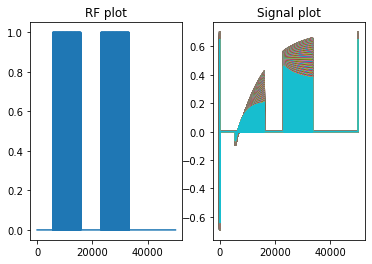

In [9]:
# see https://nilearn.github.io/stable/introduction.html#installation to install nilearn
from nilearn import image

# %% Getting B1 map and Look-Up-Table to generate the T1maps
B1avail=True
B1str=''
if B1avail:     
     ## No registration required: assuming the scanner space in the header is correct, ie little motion between the two scans
     print(imgm1.affine)
     print(imgmb1.affine)     
     imgb1r=image.resample_to_img(imgb1,imgm1,interpolation='linear')
     # to filename depends on spm version! 
     imgb1r.to_filename(sub_dir_B1+'_B1r.nii.gz')#.nii.gz
     B1map = np.squeeze(imgb1r.get_fdata())
     B1str='B1map'
else:
     #assume perfect B1: not great particularly in the temporal lobes but will output a T1map
     B1map = 100*np.ones_like(PSIR)
     B1str='no_B1map'
    
     
# %% For profiling in the notebook
# %load_ext line_profiler
# %lprun -f create_LUT create_LUT()

##Load or create LUT
LUT_file='LUT_'+protocol+'.pkl'
if not os.path.isfile(LUT_file):
     # takes about one hour on a standard PC
    if protocol=='thalamus_1080ms':
        create_LUT()
        print('UK7T LUT created')
    elif protocol=='Pitts':
        create_LUT2()
        print('Pitts LUT created')
else:
     print('Loading the LUT')

###### load LUT from pickle file #########  
with open(LUT_file,'rb') as f:
     LUT_INV1,LUT_INV2,LUT_PSIR,LUT_MP2RAGE,T1m,B1m = pickle.load(f)              

# remove initial column/row not simulated (B1 or T1 of zeros not relevant)
LUT_PSIR[0,:]=1000;LUT_MP2RAGE[0,:]=1000
LUT_PSIR[:,0]=1000;LUT_MP2RAGE[:,0]=1000
LUT_PSIR[np.isnan(LUT_PSIR)]=1000;
LUT_MP2RAGE[np.isnan(LUT_MP2RAGE)]=1000;

# Get T1 maps from data using the LUT: about 1h for UK7T protocol on a standard PC
T1psir=np.zeros_like(PSIR)
T1mp2=np.zeros_like(PSIR)
size_LUT_B1=LUT_INV1.shape[0]
size_LUT_T1=LUT_INV1.shape[1]
for z in range(0,PSIR.shape[2]):
     printProgressBar(z,PSIR.shape[2],'T1mapping progress')
     for y in range(0,PSIR.shape[1]):
          x=PSIR.shape[0]
          B1mapv=np.squeeze(B1map[:,y,z])
          PSIRv=np.squeeze(PSIR[:,y,z])
          MP2RAGEv=np.squeeze(MP2RAGE[:,y,z])
          nonzeros=(MP2RAGEv.any() and PSIRv.any() and any(B1mapv>50) and any(B1mapv<150))
          if nonzeros:
               #B1map every 10% to accelerate testing...
               # need to be in the right range, ie use B1m (range(50,151));
               # but LUT_PSIR is empty below index 50, so no need to remove these...
               # also need to be maximum B1m[-1]
               B1mapvn=np.round(B1mapv).astype(int)
               B1mapvn[B1mapvn>B1m[-1]]=B1m[-1]
            
               MP2RAGEvn=np.transpose(np.tile(MP2RAGEv,(size_LUT_T1,1)))
               PSIRvn=np.transpose(np.tile(PSIRv,(size_LUT_T1,1)))

               diffpsir=abs(PSIRvn-(LUT_PSIR[B1mapvn,:]))
               diffmp2=abs(MP2RAGEvn-(LUT_MP2RAGE[B1mapvn,:]))
               A = diffpsir.argmin(axis=1)
               B = diffmp2.argmin(axis=1)
            
               #print(A)
               #print(B)

               T1psir[:,y,z]=A
               T1mp2[:,y,z]=B

# plt.imshow(np.squeeze(T1psir[:,:,100]))

T1map_PSIR_img = nib.nifti1.Nifti1Image(T1psir, None, header=imgm1.header)
T1map_PSIR_img.to_filename(sub_dir+'_PSIR_T1map_'+B1str+'.nii.gz')

T1map_MP2_img = nib.nifti1.Nifti1Image(T1mp2, None, header=imgm1.header)
T1map_MP2_img.to_filename(sub_dir+'_MP2RAGE_T1map_'+B1str+'.nii.gz')


In [10]:
print(LUT_PSIR.shape)
print(PSIRvn.shape)
print(B1mapvn.max())
print(B1m[0])
print(B1m[-1])
print(all(B1mapv<150))
print(B1m[-1]-B1m[0])
print(LUT_PSIR[100,750:])

(201, 3001)
(512, 3001)
176
1
200
False
199
[ 0.46212603  0.46181207  0.461498   ... -0.29995124 -0.30011304
 -0.30027472]


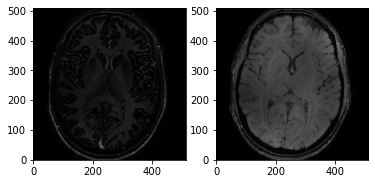

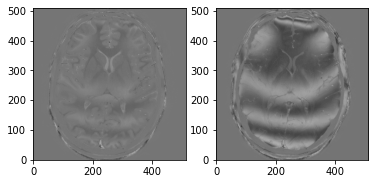

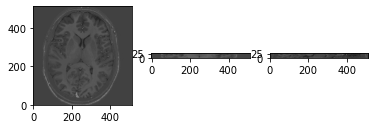

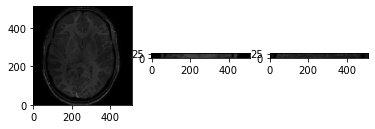

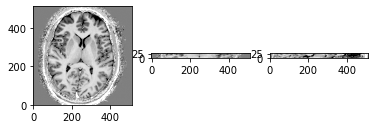

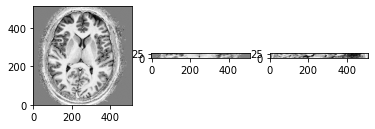

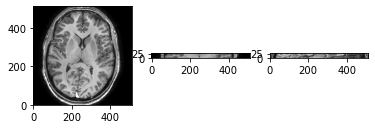

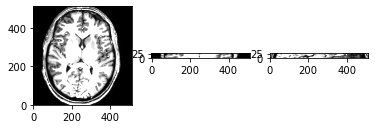

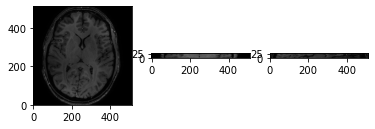

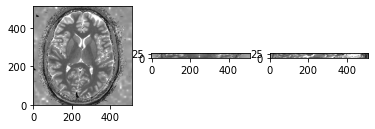

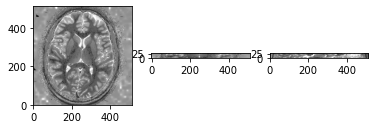

In [11]:

if show_data:
    midslice=int(imgm1_data.shape[2]/2)
    midy=int(imgm1_data.shape[1]/2)
    midx=int(imgm1_data.shape[0]/2)
    show_slices([np.abs(imgm1_data[:,:,midslice]),
                 np.abs(imgm2_data[:,:,midslice])])

    show_slices([np.real(S1[:,:,midslice]),
                 np.real(S2[:,:,midslice])])

    show_slices([S1m[:,:,midslice],S1m[:,midy,:],S1m[midx,:,:]])
    show_slices([S0[:,:,midslice],S0[:,midy,:],S0[midx,:,:]])   

    show_slices([PSIR[:,:,midslice],PSIR[:,midy,:],PSIR[midx,:,:]],[-0.5,0.5])

    show_slices([(MP2RAGE[:,:,midslice]),(MP2RAGE[:,midy,:]),(MP2RAGE[midx,:,:])],[-0.5,0.5])    

    show_slices([(PSIRbeta[:,:,midslice]),(PSIRbeta[:,midy,:]),(PSIRbeta[midx,:,:])],[0,200])
    show_slices([(MP2RAGEbeta[:,:,midslice]),(MP2RAGEbeta[:,midy,:]),(MP2RAGEbeta[midx,:,:])],[0,200]) 

    show_slices([(TI2_PSIR[:,:,midslice]),(TI2_PSIR[:,midy,:]),(TI2_PSIR[midx,:,:])])

    show_slices([(T1psir[:,:,midslice]),(T1psir[:,midy,:]),(T1psir[midx,:,:])])   
    show_slices([(T1mp2[:,:,midslice]),(T1mp2[:,midy,:]),(T1mp2[midx,:,:])])        

In [12]:
#T1psir[300,300,midslice]
B1map[300,300,midslice]
print(LUT_file)
print(LUT_PSIR[2:,2:])

LUT_thalamus_1080ms.pkl
[[ 0.61538443  0.61538443  0.61538442 ... -0.44414081 -0.44429705
  -0.44445316]
 [ 0.61538419  0.61538419  0.61538417 ... -0.44406901 -0.44422525
  -0.44438137]
 [ 0.61538386  0.61538385  0.61538382 ... -0.4439685  -0.44412474
  -0.44428086]
 ...
 [ 0.61353732  0.61351261  0.61343709 ...  0.09356768  0.09345151
   0.09333537]
 [ 0.61351853  0.61349357  0.61341729 ...  0.09714944  0.09703528
   0.09692115]
 [ 0.61349964  0.61347443  0.6133974  ...  0.10068027  0.10056808
   0.10045592]]
